In [1]:
library(here)
library(tidyverse)
library(ggrepel)
library(bdkn)
library(data.table)
library(cowplot)

here() starts at /Users/martin_petr/projects/nea-over-time
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.2.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘bdkn’

The following object is masked from ‘package:ggplot2’:

    %+%


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



In [2]:
#################################################################
##### load data
#################################################################

near_east <- c("BedouinB", "Yemenite_Jew", "Palestinian", "Iraqi_Jew", 
               "Jordanian","Druze", "Iranian", "Samaritan")

dt.asc <- readRDS('../data/rds/nea_ascertainment.rds')
dt.asc <- as.data.table(dt.asc)
dt.asc.samples <- dt.asc[sites == 'all' & snp_count > 200000 & !X %in% near_east & pop %in% c('WestEurasia', 'EMH'), unique(X)]

dt.asc.subset <- dt.asc[X %in% dt.asc.samples]
dt.asc.subset.ne <- dt.asc[X %in% dt.asc.samples | X %in% near_east]


basedir2 <- "../data/rds/"
dt.nea_est <- data.table(readRDS(sprintf("%s/%s", basedir2, "nea_estimates.rds")))

dt.nea_est <- 
  dt.nea_est %>%
  filter(!X %in% near_east,
         snp_count > 200000,
         stat == "admixture_prop" | 
           C == "Dinka" & stat == "indirect_f4" |
           C == "Dinka" & stat == "direct_f4" |
           stat == 'qpAdm',
         pop %in% c("EMH", "WestEurasia")) %>% as.data.table

In [3]:
#################################
#### functions
################################

## a function to get the "real" CI by sampling from the standard error for each point
compute_se_ci <- function(dt, my_n = 100, timespan = 45000, just_stats = F, null.m = 0) {
  dt.both_f4.reps = dt[, list(f4 = rnorm(my_n, alpha, stderr), rep = 1:my_n), by=list(X, age)]
  a = dt.both_f4.reps[, list(intercept=lm(f4~age)$coefficients[1],
                             slope=lm(f4~age)$coefficients[2]), by=rep]
  sq <- quantile(a$slope, c(.025,.5,.975))
  # print(sq)
  cat(sprintf('CI of N change over %g years\n', timespan))
  print(-sq*timespan)
  cat(sprintf('CI of slope (f4~age)\n', timespan))
  print(-sq)
  cat(sprintf('P(slope=%f) = %f\n', null.m, (1+sum(a$slope <= null.m)) / a[, .N+1]))
  
  if (just_stats) return(data.table(q025 = -sq[1]*timespan,
                                    q500 = -sq[2]*timespan,
                                    q975 = -sq[3]*timespan,
                                    p_gt0 = (1+sum(a$slope <= null.m)) / a[, .N+1]))
  
  a.ci_full <- a[, list(age = seq(0,50000,10),
                        intercept, slope), rep]
  a.ci_full[, f4 := intercept + slope * age]
  a.ci <- a.ci_full[, list(q_025 = quantile(f4, .025),
                           q_975 = quantile(f4, .975)), age]
}
dt.both_f4.ci <- compute_se_ci(dt.asc.subset[sites == 'all' & stat == 'direct_f4'])



plot_fig1 <- function(dt.nea_f4, my_n = 10000) {
  dt.nea_f4 <- data.table(dt.nea_f4)
  print('Direct f4')
  dt.nea_f4.ci.direct <- compute_se_ci(dt.nea_f4[stat == 'direct_f4'], my_n = my_n)
  print('Indirect f4')
  dt.nea_f4.ci.indirect <- compute_se_ci(dt.nea_f4[stat == 'indirect_f4'], my_n = my_n)
  dt.nea_f4[, f4 := alpha]
  ggplot(mapping=aes(x=age, y=f4)) + 
    scale_x_reverse(limits=c(46000,0)) +
    coord_cartesian(ylim=c(0,.045)) +
    
    geom_ribbon(data=dt.nea_f4.ci.indirect, aes(x=age, ymin=q_025, ymax=q_975, y=NULL, alpha='indirect_f4')) +
    geom_smooth(data=dt.nea_f4[stat=='indirect_f4'], aes(lty=stat), method='lm', se=F, color='black', size=.4) +
    
    geom_ribbon(data=dt.nea_f4.ci.direct, aes(x=age, ymin=q_025, ymax=q_975, y=NULL, alpha='direct_f4')) +
    geom_smooth(data=dt.nea_f4[stat=='direct_f4'], aes(lty=stat), method='lm', se=F, color='black') +
    
    geom_point(data=dt.nea_f4[stat=='indirect_f4'], aes(size=.5), alpha=.5, pch='x', show.legend = F) +
    geom_point(data=dt.nea_f4[stat=='direct_f4'], aes(size=snp_count/1e6), alpha=.5, stroke=0) +
    # geom_point(data=dt.nea_f4.ci, aes(x=age, y=q_025)) +
    geom_errorbar(data=dt.nea_f4[stat=='direct_f4'], aes(ymin=f4-stderr, ymax=f4+stderr), 
                  lty=1, color='black') +
    scale_size_area('SNP count\n(million)') +
    scale_linetype('statistic', 
                   labels = c('direct f4-ratio', 'indirect f4-ratio')) +
    scale_alpha_manual('statistic', values = c(.3,.1), 
                       labels = c('direct f4-ratio', 'indirect f4-ratio')) +
    theme_classic() +
    # theme(panel.grid.major = element_line(size=.1)) + #, color = rgb(1,1,1,1))) +
    # theme(legend.position = c(1,1), legend.justification = c(1.1,1.1)) +
    xlab('years before present') +
    ylab('Neandertal ancestry proportion') +
    NULL
}


CI of N change over 45000 years
         2.5%           50%         97.5% 
 0.0041302440 -0.0005432453 -0.0041814282 
CI of slope (f4~age)
         2.5%           50%         97.5% 
 9.178320e-08 -1.207212e-08 -9.292063e-08 
P(slope=0.000000) = 0.376238


In [5]:
#################################################################
##### figure 01 now w/ indirect points
#################################################################

set_dim(5, 3, 300)

# p1 <- plot_fig1(dt.asc.subset[sites == 'all'], 10000)
p1 <- plot_fig1(dt.nea_est, 10000)
# p1

[1] "Direct f4"
CI of N change over 45000 years
         2.5%           50%         97.5% 
 0.0037553879 -0.0008168173 -0.0052911930 
CI of slope (f4~age)
         2.5%           50%         97.5% 
 8.345306e-08 -1.815150e-08 -1.175821e-07 
P(slope=0.000000) = 0.360864
[1] "Indirect f4"
CI of N change over 45000 years
       2.5%         50%       97.5% 
-0.02946004 -0.03462970 -0.03984129 
CI of slope (f4~age)
         2.5%           50%         97.5% 
-6.546676e-07 -7.695490e-07 -8.853619e-07 
P(slope=0.000000) = 0.000100


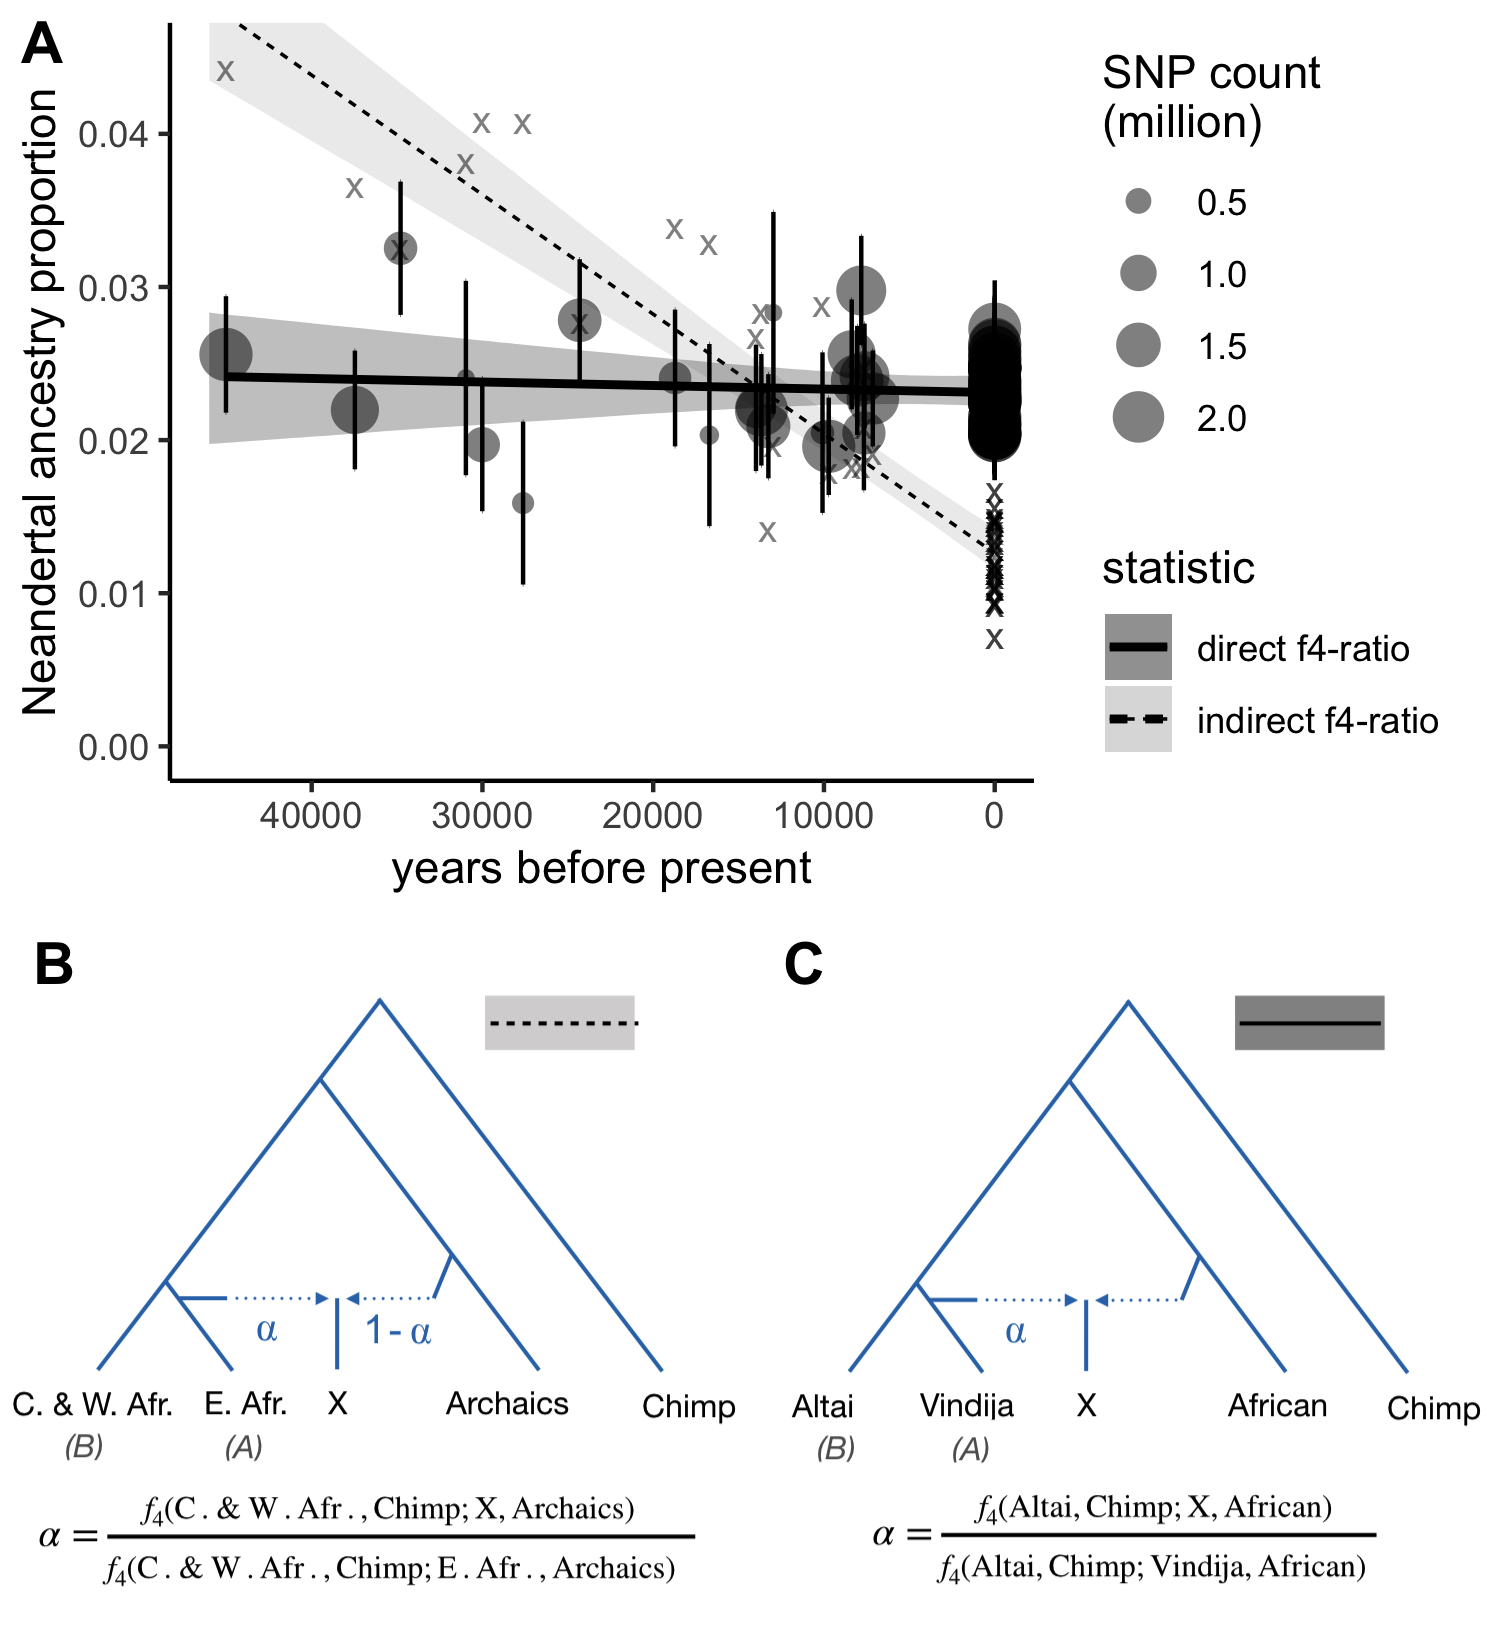

In [11]:
set_dim(5, 5.5, 300)

t1 <- ggdraw() + draw_image(here("figures/diagrams/trees_main.001.tiff"))
t2 <- ggdraw() + draw_image(here("figures/diagrams/trees_main.002.tiff"))

trees <- plot_grid(t1, t2, labels = c("B", "C"), vjust = 1.6, hjust = -0.8)

plot_grid(p1, trees, nrow = 2, labels = c("A", "", ""), rel_heights = c(1, 0.8))

ggsave(here("figures/1.pdf"), width = 5, height = 5.5, units = "in")

In [11]:
#################################################################
##### code to plot all the ascertainments - for a supplemental fig
#################################################################

ps1.all <- plot_fig1(dt.asc.subset[sites == 'all'], 1000) + 
  ggtitle(sprintf('All sites (%.1fk SNPs)', dt.asc.subset[sites == 'all', max(snp_count)/1e3]))

[1] "Direct f4"
CI of N change over 45000 years
         2.5%           50%         97.5% 
 0.0035594727 -0.0008654158 -0.0052933927 
CI of slope (f4~age)
         2.5%           50%         97.5% 
 7.909939e-08 -1.923146e-08 -1.176309e-07 
P(slope=0.000000) = 0.348651
[1] "Indirect f4"
CI of N change over 45000 years
       2.5%         50%       97.5% 
-0.02944472 -0.03464553 -0.03983456 
CI of slope (f4~age)
         2.5%           50%         97.5% 
-6.543272e-07 -7.699008e-07 -8.852125e-07 
P(slope=0.000000) = 0.000999


In [12]:
ps1.ho_afr <- plot_fig1(dt.asc.subset[sites == 'ho_afr'], 1000) + 
  ggtitle(sprintf('HO Afr (%.1fk SNPs)', dt.asc.subset[sites == 'ho_afr', max(snp_count)/1e3]))

[1] "Direct f4"
CI of N change over 45000 years
        2.5%          50%        97.5% 
 0.002378148 -0.004941055 -0.012700548 
CI of slope (f4~age)
         2.5%           50%         97.5% 
 5.284774e-08 -1.098012e-07 -2.822344e-07 
P(slope=0.000000) = 0.105894
[1] "Indirect f4"
CI of N change over 45000 years
       2.5%         50%       97.5% 
-0.02491520 -0.02988064 -0.03485104 
CI of slope (f4~age)
         2.5%           50%         97.5% 
-5.536711e-07 -6.640142e-07 -7.744675e-07 
P(slope=0.000000) = 0.000999


In [13]:
ps1.ho_nonafr <- plot_fig1(dt.asc.subset[sites == 'ho_nonafr'], 1000) + 
  ggtitle(sprintf('HO nonAfr (%.1fk SNPs)', dt.asc.subset[sites == 'ho_nonafr', max(snp_count)/1e3]))

[1] "Direct f4"
CI of N change over 45000 years
         2.5%           50%         97.5% 
-0.0004172355 -0.0079719699 -0.0151385413 
CI of slope (f4~age)
         2.5%           50%         97.5% 
-9.271899e-09 -1.771549e-07 -3.364120e-07 
P(slope=0.000000) = 0.014985
[1] "Indirect f4"
CI of N change over 45000 years
       2.5%         50%       97.5% 
-0.03247291 -0.04303083 -0.05357326 
CI of slope (f4~age)
         2.5%           50%         97.5% 
-7.216203e-07 -9.562407e-07 -1.190517e-06 
P(slope=0.000000) = 0.000999


In [14]:
ps1.bigyri_YRI <- plot_fig1(dt.asc.subset[sites == 'bigyri_YRI'], 1000) + 
  ggtitle(sprintf('YRI hets (%.1fk SNPs)', dt.asc.subset[sites == 'bigyri_YRI', max(snp_count)/1e3]))

[1] "Direct f4"
CI of N change over 45000 years
        2.5%          50%        97.5% 
 0.010621551  0.002183886 -0.006371527 
CI of slope (f4~age)
         2.5%           50%         97.5% 
 2.360345e-07  4.853080e-08 -1.415895e-07 
P(slope=0.000000) = 0.678322
[1] "Indirect f4"
CI of N change over 45000 years
       2.5%         50%       97.5% 
-0.03160221 -0.04170348 -0.05176905 
CI of slope (f4~age)
         2.5%           50%         97.5% 
-7.022714e-07 -9.267439e-07 -1.150423e-06 
P(slope=0.000000) = 0.000999


In [15]:
ps1.bigyri_Altai <- plot_fig1(dt.asc.subset[sites == 'bigyri_Altai'], 1000) + 
  ggtitle(sprintf('Altai hets (%.1fk SNPs)', dt.asc.subset[sites == 'bigyri_Altai', max(snp_count)/1e3]))

[1] "Direct f4"
CI of N change over 45000 years
        2.5%          50%        97.5% 
 0.002585804 -0.013569497 -0.029509239 
CI of slope (f4~age)
         2.5%           50%         97.5% 
 5.746230e-08 -3.015444e-07 -6.557609e-07 
P(slope=0.000000) = 0.049950
[1] "Indirect f4"
CI of N change over 45000 years
       2.5%         50%       97.5% 
-0.02574746 -0.07584295 -0.12663490 
CI of slope (f4~age)
         2.5%           50%         97.5% 
-5.721658e-07 -1.685399e-06 -2.814109e-06 
P(slope=0.000000) = 0.001998


In [16]:
ps1.afr_combined <- plot_fig1(dt.asc.subset[sites == 'afr_combined'], 1000) + 
  ggtitle(sprintf('HO Afr + YRI hets (%.1fk SNPs)', dt.asc.subset[sites == 'afr_combined', max(snp_count)/1e3]))

[1] "Direct f4"
CI of N change over 45000 years
        2.5%          50%        97.5% 
 0.003248575 -0.003006173 -0.009386512 
CI of slope (f4~age)
         2.5%           50%         97.5% 
 7.219055e-08 -6.680383e-08 -2.085892e-07 
P(slope=0.000000) = 0.171828
[1] "Indirect f4"
CI of N change over 45000 years
       2.5%         50%       97.5% 
-0.02549007 -0.03066934 -0.03584156 
CI of slope (f4~age)
         2.5%           50%         97.5% 
-5.664459e-07 -6.815409e-07 -7.964790e-07 
P(slope=0.000000) = 0.000999


In [17]:
ps1.remainder <- plot_fig1(dt.asc.subset[sites == 'remainder'], 1000) + 
  ggtitle(sprintf('Remainder (%.1fk SNPs)', dt.asc.subset[sites == 'remainder', max(snp_count)/1e3]))

[1] "Direct f4"
CI of N change over 45000 years
         2.5%           50%         97.5% 
 0.0104981816  0.0048711371 -0.0005106768 
CI of slope (f4~age)
         2.5%           50%         97.5% 
 2.332929e-07  1.082475e-07 -1.134837e-08 
P(slope=0.000000) = 0.956044
[1] "Indirect f4"
CI of N change over 45000 years
       2.5%         50%       97.5% 
-0.03150796 -0.04000442 -0.04849729 
CI of slope (f4~age)
         2.5%           50%         97.5% 
-7.001769e-07 -8.889870e-07 -1.077718e-06 
P(slope=0.000000) = 0.000999


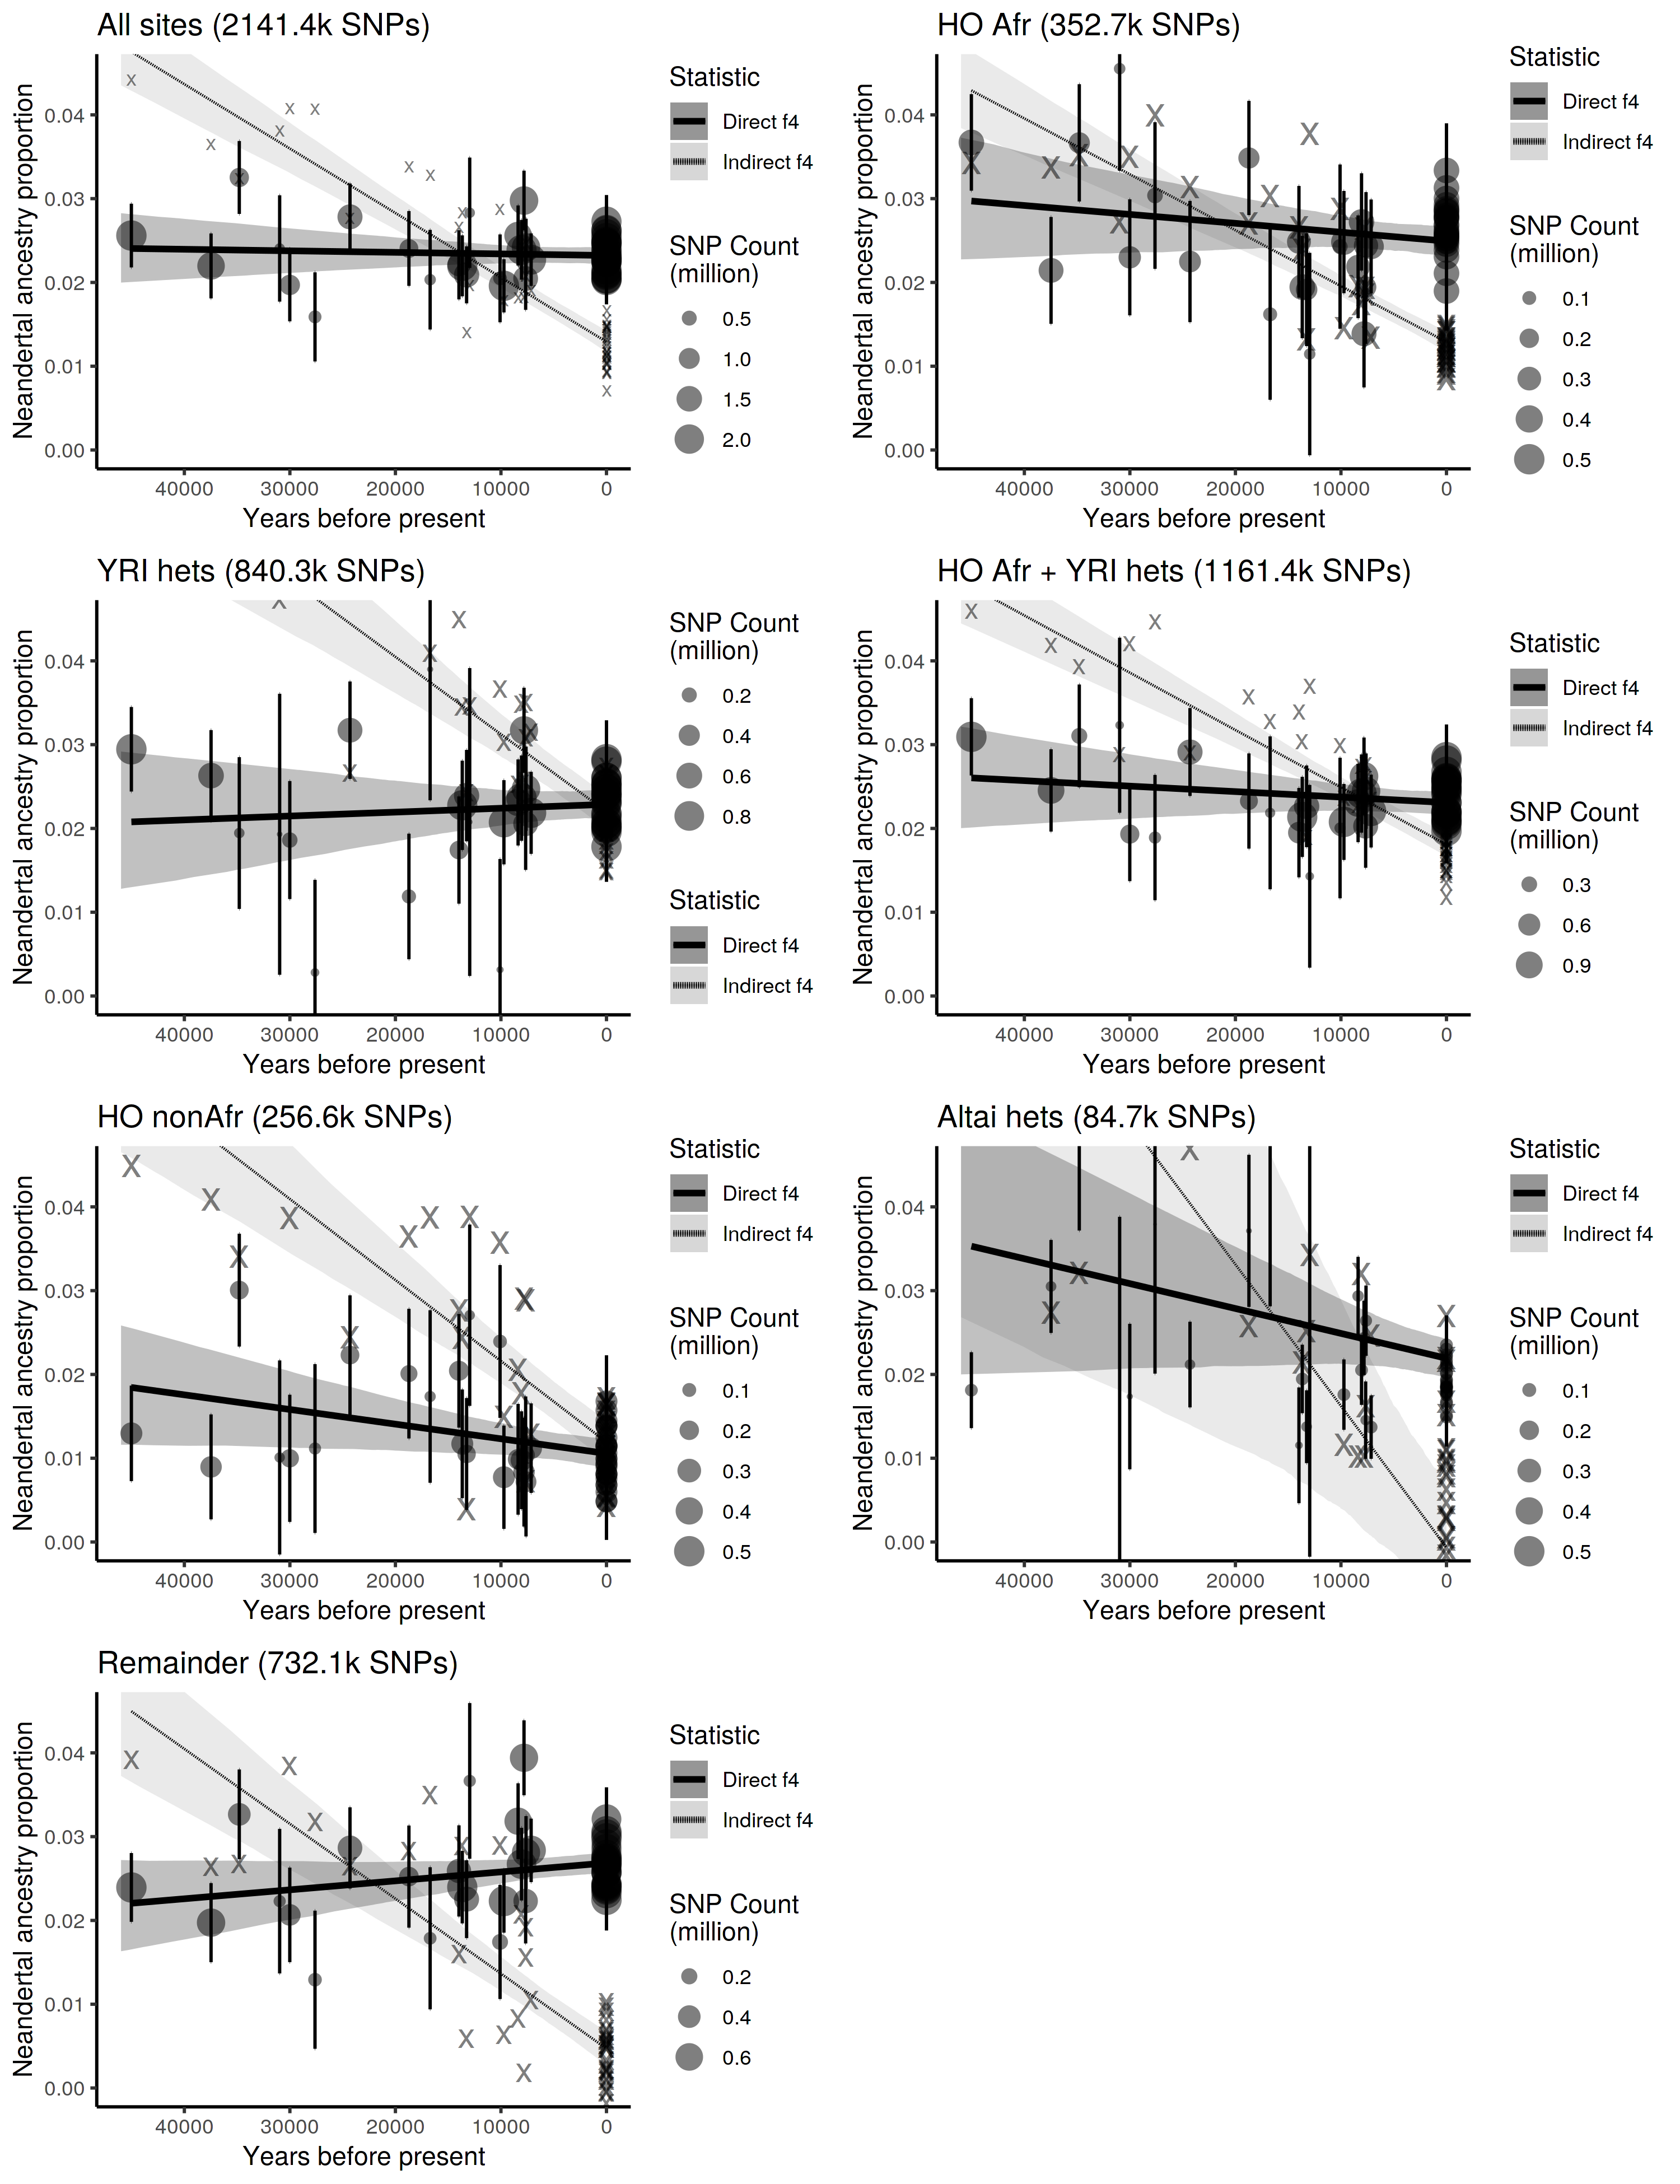

In [18]:
set_dim(10, 13, 300)

plot_grid(ps1.all, ps1.ho_afr, ps1.bigyri_YRI, ps1.afr_combined, 
          ps1.ho_nonafr, ps1.bigyri_Altai, ps1.remainder,
          ncol = 2)

region,N
ctcf_binding_site,2
enhancer,2
gap,1
open_chromatin,2
priPhastCons,1
promoter_flank,2
promoter,2
protein_coding,2
tf_binding_site,2
utr3,2


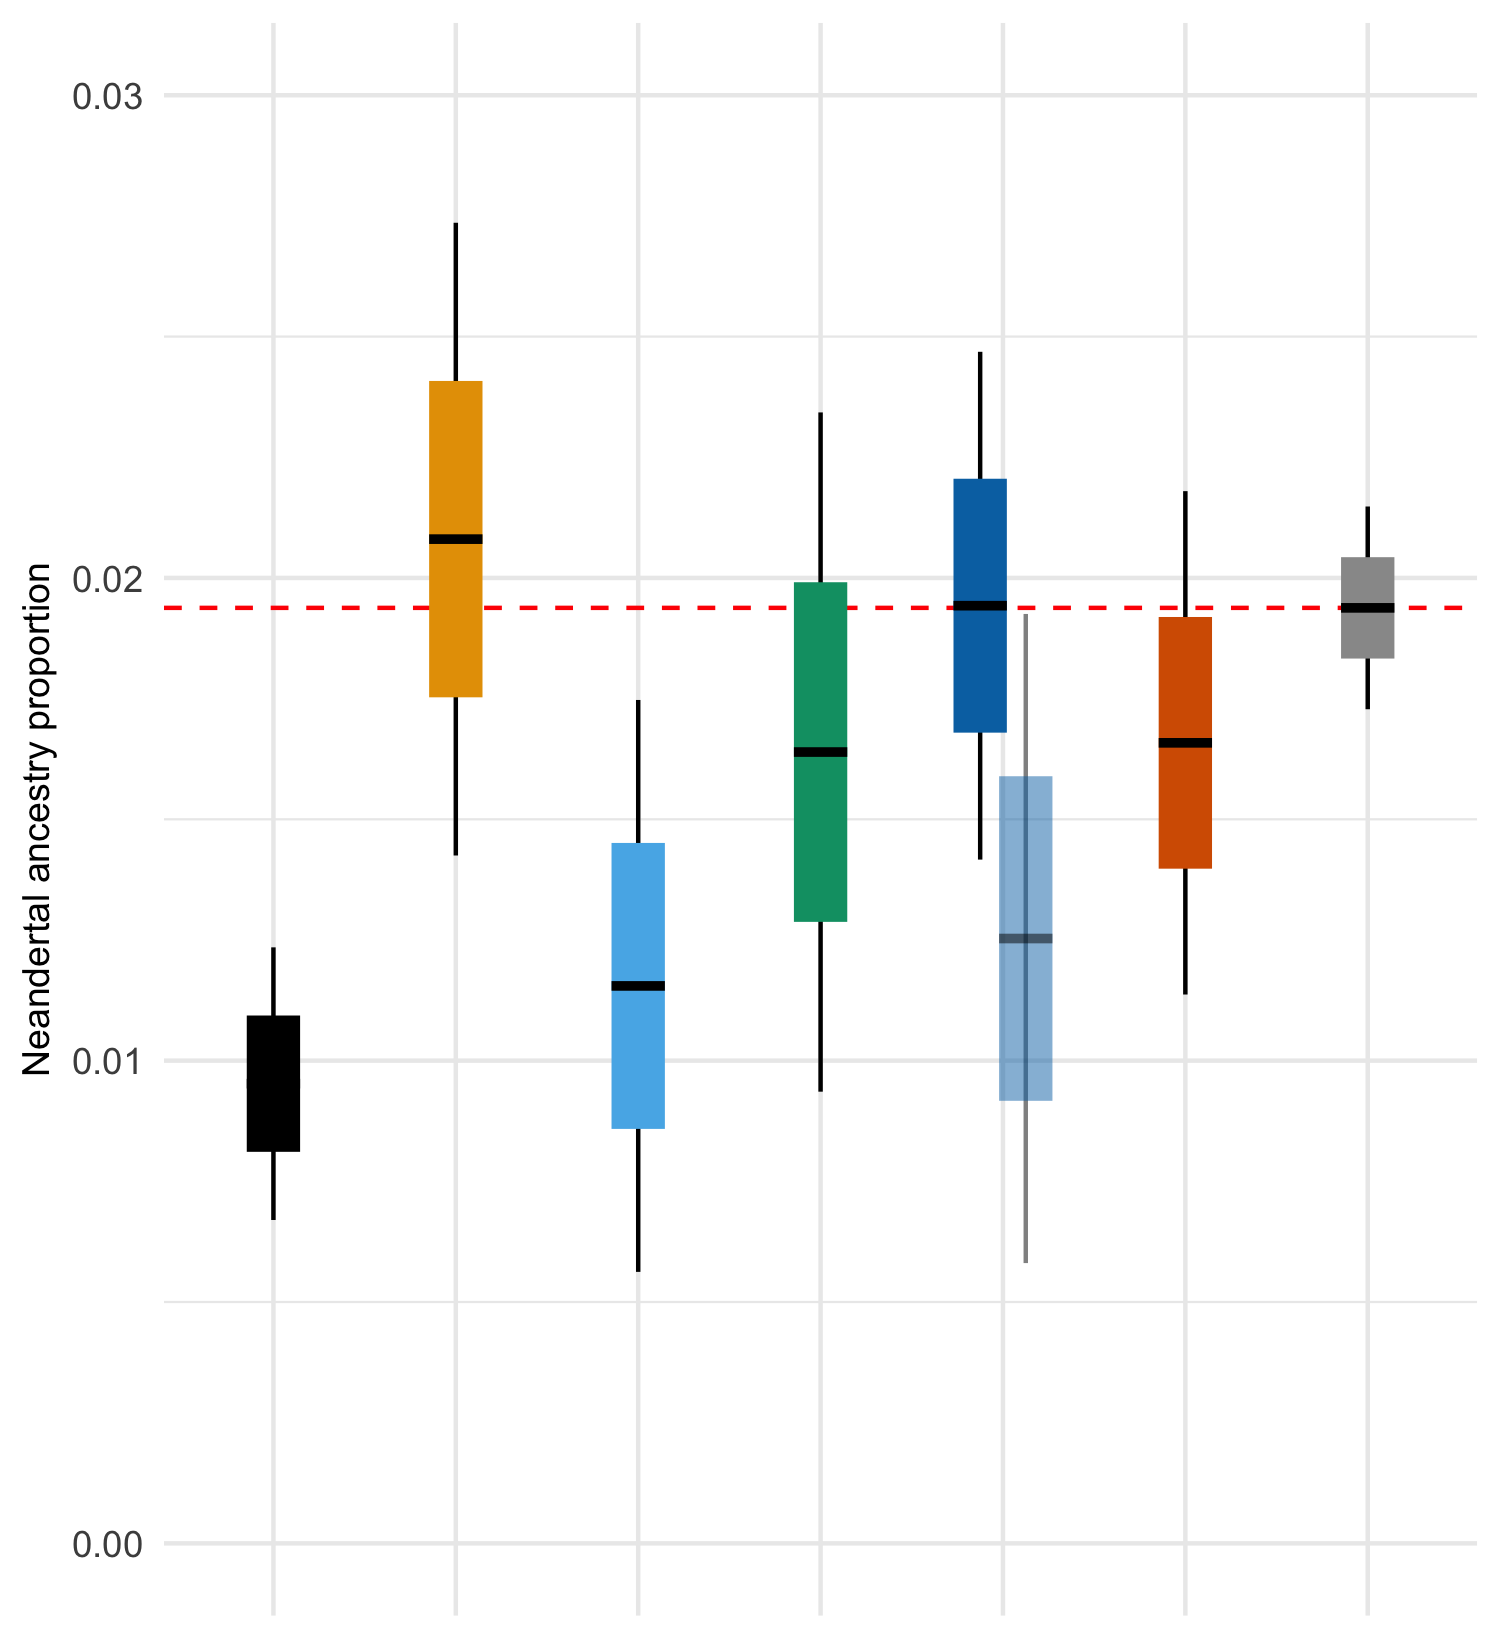

In [13]:





#############################################
#### f4 region plots
#############################################




basedir <- '~/Dropbox/martins_slow_decline/PNAS/Revised_Manuscript/revision_figures/'
region_f4 <- readRDS(sprintf('%s/%s', basedir, 'nea_in_genomic_regions.rds'))

dt.region_f4 <- data.table(region_f4)
dt.region_f4[, .N, region]

my.regions <- c('priPhastCons', 'enhancer', 'promoter', 'utr5', 'protein_coding', 'utr3', 'gap')
# my.regions2 = dt.region_f4.subset[subset == 'all', region, keyby=alpha]$region

dt.region_f4.subset <- dt.region_f4[region %in% my.regions]
dt.region_f4.subset[, region.fac := factor(region, levels = my.regions)]
dt.region_f4.subset[, region.fac2 := factor(region, levels = my.regions2)]
dt.region_f4.subset[region == 'priPhastCons', subset := 'conserved']
dt.region_f4.subset[region == 'priPhastCons', subset := 'all']

cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

p1 <- 
  ggplot(dt.region_f4.subset[subset == 'all' | region == 'protein_coding' | region == 'priPhastCons'],
             aes(x=region.fac, y=alpha, color=region.fac, group=subset)) +
  geom_hline(yintercept = median(dt.region_f4[region == 'gap', alpha]),
             linetype = 2, color = "red") +
  geom_linerange(aes(ymin=alpha-2*stderr,ymax=alpha+2*stderr, alpha=subset), color='black', size=.5, position = position_dodge(width=.5)) + 
  geom_linerange(aes(ymin=alpha-stderr,ymax=alpha+stderr, alpha=subset), size=6, position = position_dodge(width=.5)) + 
  geom_linerange(aes(ymin=alpha-.0001,ymax=alpha+.0001, alpha=subset), color='black', size=6, position = position_dodge(width=.5)) + 
  # geom_jitter(size = 0.1) +
  xlab('') +
    scale_alpha_manual(values = c(1,.5)) +
  # xlab('Genomic Region') +
    coord_cartesian(ylim=c(0,0.03)) +
  ylab('Neandertal ancestry proportion') +
  theme_bw() +
  theme(legend.position="none",
        panel.background = element_blank(),
        axis.ticks = element_blank(),
        axis.text.x = element_blank(),
        axis.title.x = element_blank(),
        panel.border = element_blank(),
        axis.title.y = element_text(size=9)) +
  # panel.grid.minor = element_line(size=.4, color='gray')) +
  # theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
  scale_color_manual(values=c('black',cbPalette[c(2,3,4,6,7,1)])) +
  NULL
p1

dt.region_f4.subset.cons_cds = dt.region_f4.subset[subset == 'conserved' & region == 'protein_coding', 
                                                   .(alpha=c(alpha,NA), stderr=c(stderr,NA), 
                                                     region, subset=c(subset,'all'), region.fac)]

p1b <- 
  ggplot(dt.region_f4.subset[subset == 'all' | region == 'protein_coding' | region == 'priPhastCons'],
         aes(x=region.fac, y=alpha, color=region.fac, group=subset)) +
  geom_hline(yintercept = median(dt.region_f4[region == 'gap', alpha]),
             linetype = 2, color = "red") +
  # geom_linerange(aes(ymin=alpha-2*stderr,ymax=alpha+2*stderr, alpha=subset), color='black', size=.5, position = position_dodge(width=.5)) + 
  # geom_linerange(aes(ymin=alpha-stderr,ymax=alpha+stderr, alpha=subset), size=6, position = position_dodge(width=.5)) + 
  geom_linerange(aes(ymin=alpha-2*stderr,ymax=alpha+2*stderr, alpha=subset), color='black', size=.5, position = position_dodge(width=.5)) + 
  geom_linerange(data=dt.region_f4.subset.cons_cds,
                 mapping=aes(ymin=alpha-stderr-.0004,ymax=alpha+stderr+.0004, alpha=subset), size=7.5, color='black', position = position_dodge(width=.5)) + 
  geom_linerange(aes(ymin=alpha-stderr,ymax=alpha+stderr, alpha=subset), size=6, position = position_dodge(width=.5)) + 
  geom_linerange(aes(ymin=alpha-.0001,ymax=alpha+.0001, alpha=subset), color='black', size=6, position = position_dodge(width=.5)) + 
  # geom_jitter(size = 0.1) +
  xlab('') +
  scale_alpha_manual(values = c(1,1)) +
  # xlab('Genomic Region') +
  coord_cartesian(ylim=c(0,0.03)) +
  ylab('Neandertal ancestry proportion') +
  theme_bw() +
  theme(legend.position="none",
        panel.background = element_blank(),
        axis.ticks = element_blank(),
        axis.text.x = element_blank(),
        axis.title.x = element_blank(),
        panel.border = element_blank(),
        axis.title.y = element_text(size=9)) +
  # panel.grid.minor = element_line(size=.4, color='gray')) +
  # theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
  scale_color_manual(values=c('black',cbPalette[c(2,3,4,6,7,1)])) +
  NULL
p1b

pdf(sprintf('%s/%s', basedir, 'svantes_iconic_gene_regions_fig.v2b.pdf'), width=6, height=3)
multiplot(p1b, p2, layout = matrix(c(1,1,1,2),ncol = 1))
dev.off()


dt.region_f4.layout <- dt.region_f4.subset[, list(y0 = 0, y1 = 1, .N), keyby=region.fac]
dt.region_f4.layout[, pos := 1:.N]
dt.region_f4.layout <- rbind(dt.region_f4.layout,
                             # dt.region_f4.layout[region.fac != 'gap'],
                             dt.region_f4.layout[region.fac == 'protein_coding'],
                             dt.region_f4.layout[region.fac == 'protein_coding'])
setkey(dt.region_f4.layout, region.fac)
dt.region_f4.layout[, pos0 := c(-.2, 1,2.2, 3.2,3.7, 4.5, 5.3,5.8, 6.8)]
dt.region_f4.layout[, pos0 := c(-.2, 1,2.2, 3.2,3.7, 4.45, 5.2,5.7, 6.7)]
dt.region_f4.layout[, pos0 := c(-.2, .95,2.15, 3.2,3.7, 4.45, 5.2,5.7, 6.7)]
# dt.region_f4.layout[region.fac == 'protein_coding', h0 := .20]
# dt.region_f4.layout[region.fac != 'protein_coding', h0 := .1]
dt.region_f4.layout[, h0 := .15]
dt.region_f4.layout[region.fac == 'gap', h0 := 0]
dt.region_f4.layout[region.fac %like% 'utr', h0 := .13]
dt.region_f4.layout[, region.lab := region.fac]
dt.region_f4.layout[region.fac == 'priPhastCons', region.lab := 'phastCons']

p2 <- ggplot(dt.region_f4.layout, 
             aes(x=pos0, y=y0, fill=region.fac)) + 
  geom_segment(x=-1, y=0, xend=8, yend=0, size=2, color=cbPalette[1]) +
  geom_segment(x=1.5, y=-.04, xend=1.6, yend=.04, size=.2) +
  geom_segment(x=1.6, y=-.04, xend=1.7, yend=.04, size=.2) +
  geom_segment(x=1.5-1.2, y=-.04, xend=1.6-1.2, yend=.04, size=.2) +
  geom_segment(x=1.6-1.2, y=-.04, xend=1.7-1.2, yend=.04, size=.2) +
  # geom_hline(yintercept = 0, size=2, color=cbPalette[1]) +
  geom_tile(aes(height=h0), width=.5) +
  theme(legend.position="none",
        panel.border = element_blank(),
        panel.background = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        axis.title = element_blank()) +
  ylim(-.25, .1) +
  xlim(-1.2, 7.1) +
  geom_text(data=dt.region_f4.layout[, list(pos0 = median(pos0),
                                            y0 = -.2), .(region.fac,region.lab)],
            aes(label = region.lab), alpha=.8) +
  scale_fill_manual(values=c('black',cbPalette[c(2,3,4,6,7,1)])) +
  NULL
p2


pdf(sprintf('%s/%s', basedir, 'svantes_iconic_gene_regions_fig.v2a.pdf'), width=6, height=3)
multiplot(p1, p2, layout = matrix(c(1,1,1,2),ncol = 1))
dev.off()

pdf(sprintf('%s/%s', basedir, 'svantes_iconic_gene_regions_fig.v2b.pdf'), width=6, height=3)
multiplot(p1b, p2, layout = matrix(c(1,1,1,2),ncol = 1))                                                                                                                  
dev.off()


##############
## another figure trial v1

my.regions <- c('gap', 'priPhastCons', 'enhancer', 'promoter', 'utr5', 'protein_coding', 'utr3')
my.regions2 = dt.region_f4.subset[subset == 'all', region, keyby=alpha]$region

dt.region_f4.subset <- dt.region_f4[region %in% my.regions]
dt.region_f4.subset[, region.fac := factor(region, levels = my.regions)]
dt.region_f4.subset[, region.fac2 := factor(region, levels = my.regions2)]
dt.region_f4.subset[region == 'priPhastCons', subset := 'conserved']
dt.region_f4.subset[region == 'priPhastCons', subset := 'all']

dt.region_f4.subset.cons_cds = dt.region_f4.subset[subset == 'conserved' & region == 'protein_coding', 
                                                   .(alpha=c(alpha,NA), stderr=c(stderr,NA), 
                                                     region, subset=c(subset,'all'), region.fac)]

p1c <- 
  ggplot(dt.region_f4.subset[subset == 'all' | region == 'protein_coding' | region == 'priPhastCons'],
         aes(x=region.fac, y=alpha, color=region.fac, group=subset)) +
  geom_hline(yintercept = median(dt.region_f4[region == 'gap', alpha]), linetype = 2, size=1, color = "black") +
  geom_hline(yintercept = median(dt.region_f4[region == 'priPhastCons', alpha]), linetype = 2, size=1, color = "gray") +
  # geom_linerange(aes(ymin=alpha-2*stderr,ymax=alpha+2*stderr, alpha=subset), color='black', size=.5, position = position_dodge(width=.5)) + 
  # geom_linerange(aes(ymin=alpha-stderr,ymax=alpha+stderr, alpha=subset), size=6, position = position_dodge(width=.5)) + 
  geom_linerange(aes(ymin=alpha-2*stderr,ymax=alpha+2*stderr, alpha=subset), color='black', size=.5, position = position_dodge(width=.5)) + 
  # geom_linerange(data=dt.region_f4.subset.cons_cds,
  #                mapping=aes(ymin=alpha-stderr-.0004,ymax=alpha+stderr+.0004, alpha=subset), size=7.5, color='black', position = position_dodge(width=.5)) + 
  geom_linerange(aes(ymin=alpha-stderr,ymax=alpha+stderr, alpha=subset), size=6, position = position_dodge(width=.5)) + 
  geom_linerange(aes(ymin=alpha-.0001,ymax=alpha+.0001, alpha=subset), color='black', size=6, position = position_dodge(width=.5)) + 
  # geom_jitter(size = 0.1) +
  xlab('') +
  scale_alpha_manual(values = c(1,.6)) +
  # xlab('Genomic Region') +
  coord_cartesian(ylim=c(0,0.03)) +
  ylab('Neandertal ancestry proportion') +
  theme_bw() +
  theme(legend.position="none",
        panel.background = element_blank(),
        axis.ticks = element_blank(),
        axis.text.x = element_blank(),
        axis.title.x = element_blank(),
        panel.border = element_blank(),
        axis.title.y = element_text(size=9)) +
  # panel.grid.minor = element_line(size=.4, color='gray')) +
  # theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
  scale_color_manual(values=c('black','gray',cbPalette[c(3,2,6,7,4)])) +
  NULL
p1c
multiplot(p1c, p2, layout = matrix(c(1,1,1,2),ncol = 1))

pdf(sprintf('%s/%s', basedir, 'svantes_iconic_gene_regions_fig.v2c.pdf'), width=6.5, height=3.5)
multiplot(p1c, p2, layout = matrix(c(1,1,1,2),ncol = 1))
dev.off()


dt.region_f4.layout <- dt.region_f4.subset[, list(y0 = 0, y1 = 1, .N), keyby=region.fac]
dt.region_f4.layout <- dt.region_f4.subset[, list(y0 = 0, y1 = 1, .N), keyby=region.fac]
dt.region_f4.layout[, pos := 1:.N]
dt.region_f4.layout <- rbind(dt.region_f4.layout,
                             # dt.region_f4.layout[region.fac != 'gap'],
                             dt.region_f4.layout[region.fac == 'protein_coding'],
                             dt.region_f4.layout[region.fac == 'protein_coding'])
setkey(dt.region_f4.layout, region.fac)
dt.region_f4.layout[, pos0 := c(-.2, 1,2.2, 3.2,3.7, 4.5, 5.3,5.8, 6.8)]
dt.region_f4.layout[, pos0 := c(-.2, 1,2.2, 3.2,3.7, 4.45, 5.2,5.7, 6.7)]
dt.region_f4.layout[, pos0 := c(-.2, .95,2.15, 3.2,3.7, 4.45, 5.2,5.7, 6.7)]
dt.region_f4.layout[, pos0 := c(-1.45, -.2, .95,2.15, 3.2,3.7, 4.45, 5.2,5.7)]
# dt.region_f4.layout[region.fac == 'protein_coding', h0 := .20]
# dt.region_f4.layout[region.fac != 'protein_coding', h0 := .1]
dt.region_f4.layout[, h0 := .15]
dt.region_f4.layout[region.fac == 'gap', h0 := 0]
dt.region_f4.layout[region.fac == 'priPhastCons', h0 := 0]
dt.region_f4.layout[region.fac %like% 'utr', h0 := .13]
dt.region_f4.layout[, region.lab := region.fac]
dt.region_f4.layout[region.fac == 'priPhastCons', region.lab := 'phastCons']

p2 <- ggplot(dt.region_f4.layout, 
             aes(x=pos0, y=y0, fill=region.fac)) + 
  # geom_segment(x=-1, y=0, xend=8, yend=0, size=2, color=cbPalette[1]) +
  geom_segment(x=-2, y=0, xend=6.5, yend=0, size=2, color='black', lty=1) +
  geom_segment(x=1.5-.05, y=-.04, xend=1.6-.05, yend=.04, size=.2) +
  geom_segment(x=1.6-.05, y=-.04, xend=1.7-.05, yend=.04, size=.2) +
  # geom_hline(yintercept = 0, size=2, color=cbPalette[1]) +
  geom_tile(aes(height=h0), width=.5) +
  geom_segment(x=-.6, y=0, xend=.1, yend=0, size=2, color='grey', lty=1) +
  # geom_segment(x=4.5, y=0, xend=4.7, yend=0, size=2, color='grey', lty=1) +
  # geom_segment(x=4.95, y=0, xend=5.45, yend=0, size=2, color='grey', lty=1) +
  geom_segment(x=4.6, y=0, xend=5.45, yend=0, size=2, color='grey', lty=1) +
  theme(legend.position="none",
        panel.border = element_blank(),
        panel.background = element_blank(),
        line = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        axis.title = element_blank()) +
  ylim(-.25, .1) +
  coord_cartesian(xlim=c(-2.2, 5.9)) +
  geom_text(data=dt.region_f4.layout[, list(pos0 = median(pos0),
                                            y0 = -.2), .(region.fac,region.lab)],
            aes(label = region.lab), alpha=.8) +
  scale_fill_manual(values=c('gray','black',cbPalette[c(3,2,6,7,4)])) +
  NULL
#p2
multiplot(p1c, p2, layout = matrix(c(1,1,1,2),ncol = 1))
  
pdf(sprintf('%s/%s', basedir, 'svantes_iconic_gene_regions_fig.v2d.pdf'), width=6.5, height=3.5)
multiplot(p1c, p2, layout = matrix(c(1,1,1,2),ncol = 1))
dev.off()


##############
## another figure trial v1

my.regions <- c('priPhastCons', 'enhancer', 'promoter', 'utr5', 'protein_coding', 'utr3')

dt.region_f4.subset <- dt.region_f4[region %in% my.regions]
my.regions2 = dt.region_f4.subset[subset == 'all', region, keyby=alpha]$region
dt.region_f4.subset[, region.fac := factor(region, levels = my.regions)]
dt.region_f4.subset[, region.fac2 := factor(region, levels = my.regions2)]
dt.region_f4.subset[region == 'priPhastCons', subset := 'conserved']
dt.region_f4.subset[region == 'priPhastCons', subset := 'all']

dt.region_f4.subset.cons_cds = dt.region_f4.subset[subset == 'conserved' & region == 'protein_coding', 
                                                   .(alpha=c(alpha,NA), stderr=c(stderr,NA), 
                                                     region, subset=c(subset,'all'), region.fac)]

p1d <- 
  ggplot(dt.region_f4.subset[subset == 'all' | region == 'protein_coding' | region == 'priPhastCons'],
         aes(x=region.fac, y=alpha, color=region.fac, group=subset)) +
  geom_hline(yintercept = median(dt.region_f4[region == 'gap', alpha]), linetype = 2, size=1, color = "black") +
  geom_hline(yintercept = median(dt.region_f4[region == 'priPhastCons', alpha]), linetype = 2, size=1, color = "gray") +
  # geom_linerange(aes(ymin=alpha-2*stderr,ymax=alpha+2*stderr, alpha=subset), color='black', size=.5, position = position_dodge(width=.5)) + 
  # geom_linerange(aes(ymin=alpha-stderr,ymax=alpha+stderr, alpha=subset), size=6, position = position_dodge(width=.5)) + 
  geom_linerange(aes(ymin=alpha-2*stderr,ymax=alpha+2*stderr, alpha=subset), color='black', size=.5, position = position_dodge(width=.5)) + 
  # geom_linerange(data=dt.region_f4.subset.cons_cds,
  #                mapping=aes(ymin=alpha-stderr-.0004,ymax=alpha+stderr+.0004, alpha=subset), size=7.5, color='black', position = position_dodge(width=.5)) + 
  geom_linerange(aes(ymin=alpha-stderr,ymax=alpha+stderr, alpha=subset), size=6, position = position_dodge(width=.5)) + 
  geom_linerange(aes(ymin=alpha-.0001,ymax=alpha+.0001, alpha=subset), color='black', size=6, position = position_dodge(width=.5)) + 
  # geom_jitter(size = 0.1) +
  xlab('') +
  scale_alpha_manual(values = c(1,.6)) +
  # xlab('Genomic Region') +
  coord_cartesian(ylim=c(0,0.03)) +
  ylab('Neandertal ancestry proportion') +
  theme_bw() +
  theme(legend.position="none",
        panel.background = element_blank(),
        axis.ticks = element_blank(),
        axis.text.x = element_blank(),
        axis.title.x = element_blank(),
        panel.border = element_blank(),
        axis.title.y = element_text(size=9)) +
  # panel.grid.minor = element_line(size=.4, color='gray')) +
  # theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
  scale_color_manual(values=c('gray',cbPalette[c(3,2,6,7,4)])) +
  NULL
p1d
multiplot(p1d, p2, layout = matrix(c(1,1,1,2),ncol = 1))

pdf(sprintf('%s/%s', basedir, 'svantes_iconic_gene_regions_fig.v2d.pdf'), width=6.5, height=3.5)
multiplot(p1d, p2d, layout = matrix(c(1,1,1,2),ncol = 1))
dev.off()


dt.region_f4.layout <- dt.region_f4.subset[, list(y0 = 0, y1 = 1, .N), keyby=region.fac]
dt.region_f4.layout <- dt.region_f4.subset[, list(y0 = 0, y1 = 1, .N), keyby=region.fac]
dt.region_f4.layout[, pos := 1:.N]
dt.region_f4.layout <- rbind(dt.region_f4.layout,
                             # dt.region_f4.layout[region.fac != 'gap'],
                             dt.region_f4.layout[region.fac == 'protein_coding'],
                             dt.region_f4.layout[region.fac == 'protein_coding'])
setkey(dt.region_f4.layout, region.fac)
dt.region_f4.layout[, pos0 := c(-.2, 1,2.2, 3.2,3.7, 4.5, 5.3,5.8, 6.8)]
dt.region_f4.layout[, pos0 := c(-.2, 1,2.2, 3.2,3.7, 4.45, 5.2,5.7, 6.7)]
dt.region_f4.layout[, pos0 := c(-.2, .95,2.15, 3.2,3.7, 4.45, 5.2,5.7)]
# dt.region_f4.layout[, pos0 := c(-1.45, -.2, .95,2.15, 3.2,3.7, 4.45, 5.2,5.7)]
# dt.region_f4.layout[region.fac == 'protein_coding', h0 := .20]
# dt.region_f4.layout[region.fac != 'protein_coding', h0 := .1]
dt.region_f4.layout[, h0 := .15]
dt.region_f4.layout[region.fac == 'gap', h0 := 0]
dt.region_f4.layout[region.fac == 'priPhastCons', h0 := 0]
dt.region_f4.layout[region.fac %like% 'utr', h0 := .13]
dt.region_f4.layout[, region.lab := region.fac]
dt.region_f4.layout[region.fac == 'priPhastCons', region.lab := 'phastCons']

p2d <- ggplot(dt.region_f4.layout, 
             aes(x=pos0, y=y0, fill=region.fac)) + 
  # geom_segment(x=-1, y=0, xend=8, yend=0, size=2, color=cbPalette[1]) +
  geom_segment(x=-1, y=0, xend=6.5, yend=0, size=2, color='black', lty=1) +
  geom_segment(x=1.5-.05, y=-.04, xend=1.6-.05, yend=.04, size=.2) +
  geom_segment(x=1.6-.05, y=-.04, xend=1.7-.05, yend=.04, size=.2) +
  # geom_hline(yintercept = 0, size=2, color=cbPalette[1]) +
  geom_tile(aes(height=h0), width=.5) +
  geom_segment(x=-.4, y=0, xend=0, yend=0, size=2, color='grey', lty=1) +
  # geom_segment(x=4.5, y=0, xend=4.7, yend=0, size=2, color='grey', lty=1) +
  # geom_segment(x=4.95, y=0, xend=5.45, yend=0, size=2, color='grey', lty=1) +
  # geom_segment(x=4.6, y=0, xend=5.45, yend=0, size=2, color='grey', lty=1) +
  theme(legend.position="none",
        panel.border = element_blank(),
        panel.background = element_blank(),
        line = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        axis.title = element_blank()) +
  ylim(-.25, .1) +
  coord_cartesian(xlim=c(-1.1, 5.9)) +
  geom_text(data=dt.region_f4.layout[, list(pos0 = median(pos0),
                                            y0 = -.2), .(region.fac,region.lab)],
            aes(label = region.lab), alpha=.8) +
  scale_fill_manual(values=c('gray',cbPalette[c(3,2,6,7,4)])) +
  NULL
#p2d
multiplot(p1d, p2d, layout = matrix(c(1,1,1,2),ncol = 1))

pdf(sprintf('%s/%s', basedir, 'svantes_iconic_gene_regions_fig.v2d.pdf'), width=6.5, height=3.5)
multiplot(p1d, p2d, layout = matrix(c(1,1,1,2),ncol = 1))
dev.off()





##############
## another figure trial v1

my.regions <- c('priPhastCons', 'enhancer', 'promoter', 'utr5', 'protein_coding', 'CDS', 'utr3')

dt.region_f4.subset <- dt.region_f4[region %in% my.regions]
dt.region_f4.subset[region == 'protein_coding', region := 'CDS']
my.regions2 = dt.region_f4.subset[subset == 'all', region, keyby=alpha]$region
dt.region_f4.subset[, region.fac := factor(region, levels = my.regions)]
dt.region_f4.subset[, region.fac2 := factor(region, levels = my.regions2)]
dt.region_f4.subset[region == 'priPhastCons', subset := 'conserved']
dt.region_f4.subset[region == 'priPhastCons', subset := 'all']

dt.region_f4.subset.cons_cds = dt.region_f4.subset[subset == 'conserved' & region == 'CDS', 
                                                   .(alpha=c(alpha,NA), stderr=c(stderr,NA), 
                                                     region, subset=c(subset,'all'), region.fac)]

p1e <- 
  ggplot(dt.region_f4.subset[subset == 'all' | region == 'CDS' | region == 'priPhastCons'],
         aes(x=region.fac, y=alpha, color=region.fac, group=subset)) +
  geom_hline(yintercept = median(dt.region_f4[region == 'gap', alpha]), linetype = 2, size=1, color = "black") +
  geom_hline(yintercept = median(dt.region_f4[region == 'priPhastCons', alpha]), linetype = 2, size=1, color = "gray") +
  geom_linerange(aes(ymin=alpha-2*stderr,ymax=alpha+2*stderr, alpha=subset), color='black', size=.5, position = position_dodge(width=.5)) + 
  geom_linerange(aes(ymin=alpha-stderr,ymax=alpha+stderr, alpha=subset), size=6, position = position_dodge(width=.5)) + 
  geom_linerange(aes(ymin=alpha-.0001,ymax=alpha+.0001, alpha=subset), color='black', size=6, position = position_dodge(width=.5)) + 
  xlab('') +
  scale_alpha_manual(values = c(1,.6)) +
  coord_cartesian(ylim=c(0.001,0.027)) +
  ylab('Neandertal ancestry proportion') +
  theme_bw() +
  theme(legend.position="none",
        panel.background = element_blank(),
        axis.ticks = element_blank(),
        axis.text.x = element_blank(),
        axis.title.x = element_blank(),
        panel.border = element_blank(),
        axis.title.y = element_text(size=13)) +
  # panel.grid.minor = element_line(size=.4, color='gray')) +
  # theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
  scale_color_manual(values=c('gray',cbPalette[c(3,2,6,7,4)])) +
  NULL
p1e
multiplot(p1e, p2e, layout = matrix(c(1,1,1,2),ncol = 1))

pdf(sprintf('%s/%s', basedir, 'svantes_iconic_gene_regions_fig.v2e.pdf'), width=6.5, height=3.5)
multiplot(p1e, p2e, layout = matrix(c(1,1,1,2),ncol = 1))
dev.off()


dt.region_f4.layout <- dt.region_f4.subset[, list(y0 = 0, y1 = 1, .N), keyby=region.fac]
dt.region_f4.layout <- dt.region_f4.subset[, list(y0 = 0, y1 = 1, .N), keyby=region.fac]
dt.region_f4.layout[, pos := 1:.N]
dt.region_f4.layout <- rbind(dt.region_f4.layout,
                             # dt.region_f4.layout[region.fac != 'gap'],
                             dt.region_f4.layout[region.fac == 'CDS'],
                             dt.region_f4.layout[region.fac == 'CDS'])
setkey(dt.region_f4.layout, region.fac)
dt.region_f4.layout[, pos0 := c(-.2, 1,2.2, 3.2,3.7, 4.5, 5.3,5.8, 6.8)]
dt.region_f4.layout[, pos0 := c(-.2, 1,2.2, 3.2,3.7, 4.45, 5.2,5.7, 6.7)]
dt.region_f4.layout[, pos0 := c(-.2, .95,2.15, 3.2,3.7, 4.45, 5.2,5.7)]
dt.region_f4.layout[, h0 := .15]
dt.region_f4.layout[region.fac == 'gap', h0 := 0]
dt.region_f4.layout[region.fac == 'priPhastCons', h0 := 0]
dt.region_f4.layout[region.fac %like% 'utr', h0 := .13]
dt.region_f4.layout[, region.lab := region.fac]
dt.region_f4.layout[region.fac == 'priPhastCons', region.lab := 'phastCons']

p2e <- ggplot(dt.region_f4.layout, 
              aes(x=pos0, y=y0, fill=region.fac)) + 
  geom_segment(x=-1, y=0, xend=6.5, yend=0, size=2, color='black', lty=1) +
  geom_segment(x=1.5-.05, y=-.04, xend=1.6-.05, yend=.04, size=.2) +
  geom_segment(x=1.6-.05, y=-.04, xend=1.7-.05, yend=.04, size=.2) +
  geom_tile(aes(height=h0), width=.5) +
  geom_segment(x=-.4, y=0, xend=0, yend=0, size=2, color='grey', lty=1) +
  theme(legend.position="none",
        panel.border = element_blank(),
        panel.background = element_blank(),
        line = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        axis.title = element_blank()) +
  ylim(-.25, .1) +
  coord_cartesian(xlim=c(-1.1, 5.9)) +
  geom_text(data=dt.region_f4.layout[, list(pos0 = median(pos0),
                                            y0 = -.2), .(region.fac,region.lab)],
            aes(label = region.lab), alpha=.8) +
  scale_fill_manual(values=c('gray',cbPalette[c(3,2,6,7,4)])) +
  NULL
#p2e
multiplot(p1e, p2e, layout = matrix(c(1,1,1,2),ncol = 1))

pdf(sprintf('%s/%s', basedir, 'svantes_iconic_gene_regions_fig.v2e.pdf'), width=5.5, height=3.5)
multiplot(p1e, p2e, layout = matrix(c(1,1,1,2),ncol = 1))
dev.off()



#############
## region f4 CI
####

compute_se_ci_vs_target <- function(dt, my_n = 100, just_stats = F, null.m = 0) {
  
  if (dt[, .N] != 1) {
    cat('Function requires a single row in dt.\n')
    return()
  }
  dt = data.table(dt[1])

  dt.reps = dt[, list(f4 = rnorm(my_n, alpha, stderr), rep = 1:my_n)]
  
  # get the average N for each resampling and group
  pval.low = dt.reps[, (sum(f4 <= null.m) + 1) / (.N + 1)]
  pval.high = dt.reps[, (sum(f4 >= null.m) + 1) / (.N + 1)]
  # print(sq)
  cat(sprintf('%%N: %g [95%% CI = %0.3g-%0.3g]\n', 
              dt$alpha, 
              quantile(dt.reps$f4, .025),
              quantile(dt.reps$f4, .975)))
  cat(sprintf('depletion: %g\n', 
              1-dt$alpha / null.m))
  cat(sprintf('p-value:\n  N < %g: %g\n  N > %g: %g\n', 
              null.m,pval.low,
              null.m,pval.high))
}

compute_se_ci_vs_target(dt.region_f4[region == 'protein_coding' & subset == 'conserved'], 
                        null.m=dt.region_f4[region == 'gap', alpha], my_n = 1000000)

for (my.r in my.regions) {
  cat('\n',my.r, '\n')
  compute_se_ci_vs_target(dt.region_f4[region == my.r & subset == 'all'], 
                          null.m=dt.region_f4[region == 'gap', alpha], my_n = 1000000)
}

